# ORCHIDSS Deep DDF Target Selection

In [232]:
%matplotlib inline

import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, join
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.stats import bootstrap
from astropy.utils import NumpyRNGContext
from astropy.io import fits
from astropy.wcs import WCS
from mocpy import MOC
import eazy

# Symlink templates & filters from the eazy-code repository
try:
    print('EAZYCODE = '+os.getenv('EAZYCODE'))
except:
    pass

if not os.path.exists('templates'):
    eazy.symlink_eazy_inputs() 
    
def calcStats(photoz, specz):
    cut = np.logical_and(photoz >= 0, specz > 0.00)
    print('NGD: {0}'.format(cut.sum()))
    dz = photoz - specz

    ol1 = (np.abs(dz)/(1+specz) > 0.2)
    nmad = 1.48 * np.median( np.abs(dz[cut] - np.median(dz[cut])) / (1+specz[cut]))
    ol2 = (np.abs(dz)/(1+specz) > 5*nmad )
    OLF1 = np.sum( ol1[cut] ) / float(len(dz[cut]))
    OLF2 = np.sum( ol2[cut] ) / float(len(dz[cut]))

    print('NMAD: {0:.4f}'.format(nmad))
    #print('Bias: {0:.4f}'.format(np.nanmedian(dz[cut]/(1+specz[cut]))))
    #print('Bias: {0:.4f}'.format(np.nanmedian(dz[cut])))
    print('OLF: Def1 = {0:.4f} Def2 = {1:0.4f}'.format(OLF1, OLF2))
    print('\n')

    ol1_s, ol2_s = np.invert(ol1), np.invert(ol2)

    return ol1_s, ol2_s, np.nanmedian(dz[ol1_s]/(1+specz[ol1_s]))

EAZYCODE = Users/duncan/Astro/code/eazy-py/eazy-photoz


## Overall outline

The broad steps in the final ORCHIDSS deep sample selection are as follows:
1. Load the combined WAVES DDF photo-$z$ catalogues, merge with the corresponding optical catalogues to retain additional relevant columns (i.e. AESOP footprint mask). For the optical catalogue merging, we apply the following initial primary criteria:
    - `mask == 0` - within the DDF AESOP footprint
    - `duplicate == 0` - duplicate source (from overlapping tiles) removed 
2. Match the sample to the MIGHTEE DR1(2) radio catalogue and perform forced photometry on the associated mosaic. The optical/radio matching and forced photometry is performed using the same approach as the ORCHIDSSwide_ddf notebooks.
3. Optimise the final sample selection thresholds.
4. Compare with ORCHIDSSwide_ddf overlap and assess overall fibre allocation.

Also folded in for use later are the ETC predictions for the subset of optical sources with `P140_gpz > 0.5` (i.e. much lower than the likely threshold to be employed).

In [233]:
### COSMOS
wd10 = pd.read_parquet('../InputCatalogues/photoz/WD10_Photoz_Combined_c_Sabine Bellstedt.parquet')
wd10 = Table.from_pandas(wd10)

wd10_opt = Table.from_pandas(pd.read_parquet('../InputCatalogues/optical/WD10_2p4.parquet'))

wd10_opt.keep_columns(['uberID', 'mask', 'starmask', 'duplicate', 'mag_app_rt'])
wd10_opt['uberID'] = np.array(wd10_opt['uberID'], dtype=np.int64)

wd10 = join(wd10, wd10_opt, keys='uberID')
wd10.sort('uberID')

masked = (wd10['mask'] == 0) * (wd10['duplicate'] == 0.)

wd10 = wd10[masked]

wd10_etc = Table.read('../InputCatalogues/etc_outputs/WD10_orchidss_ParentCat_forETC_boostedSNR_nosharedtargets_correct_output_ETC2024-05-20_10 33 53.fits')
wd10_etc['NAME'].name = 'uberID'
wd10_etc['uberID'] = np.array(wd10_etc['uberID'], dtype=np.int64)

wd10_etcm = join(wd10[['uberID']], wd10_etc, join_type='left', keys='uberID')
wd10_etcm.sort('uberID')

cos_coord = SkyCoord(wd10['RAGAIA_r'], wd10['DecGAIA_r'], unit='deg')

In [234]:
### XMM-LSS
wd02 = pd.read_parquet('../InputCatalogues/photoz/WD02_Photoz_Combined_c_Sabine Bellstedt.parquet')
wd02 = Table.from_pandas(wd02)

wd02_opt = Table.from_pandas(pd.read_parquet('../InputCatalogues/optical/WD02_2p4.parquet'))

wd02_opt.keep_columns(['uberID', 'mask', 'starmask', 'duplicate', 'mag_app_rt'])
wd02_opt['uberID'] = np.array(wd02_opt['uberID'], dtype=np.int64)

wd02 = join(wd02, wd02_opt, keys='uberID')
wd02.sort('uberID')

masked = (wd02['mask'] == 0) * (wd02['duplicate'] == 0.)

wd02 = wd02[masked]

wd02_etc = Table.read('../InputCatalogues/etc_outputs/WD02_orchidss_ParentCat_forETC_boostedSNR_nosharedtargets_correct_output_ETC2024-05-20_10 33 35.fits')
wd02_etc['NAME'].name = 'uberID'
wd02_etc['uberID'] = np.array(wd02_etc['uberID'], dtype=np.int64)

wd02_etcm = join(wd02[['uberID']], wd02_etc, join_type='left', keys='uberID')
wd02_etcm.sort('uberID')

xmm_coord = SkyCoord(wd02['RAGAIA_r'], wd02['DecGAIA_r'], unit='deg')

In [235]:
### ECDFS
wd03 = pd.read_parquet('../InputCatalogues/photoz/WD03_Photoz_Combined_c_Sabine Bellstedt.parquet')
wd03 = Table.from_pandas(wd03)

wd03_opt = Table.from_pandas(pd.read_parquet('../InputCatalogues/optical/WD03_2p4.parquet'))

wd03_opt.keep_columns(['uberID', 'mask', 'starmask', 'duplicate', 'mag_app_rt'])
wd03_opt['uberID'] = np.array(wd03_opt['uberID'], dtype=np.int64)

wd03 = join(wd03, wd03_opt, keys='uberID')
wd03.sort('uberID')

masked = (wd03['mask'] == 0) * (wd03['duplicate'] == 0.)

wd03 = wd03[masked]

wd03_etc = Table.read('../InputCatalogues/etc_outputs/WD03_orchidss_ParentCat_forETC_boostedSNR_nosharedtargets_correct_output_ETC2024-05-20_10 44 23.fits')
wd03_etc['NAME'].name = 'uberID'
wd03_etc['uberID'] = np.array(wd03_etc['uberID'], dtype=np.int64)

wd03_etcm = join(wd03[['uberID']], wd03_etc, join_type='left', keys='uberID')
wd03_etcm.sort('uberID')

cdfs_coord = SkyCoord(wd03['RAGAIA_r'], wd03['DecGAIA_r'], unit='deg')

In [236]:
# ddf2ra = np.array([36.18513, 36.82208, 36.18731, 34.91264, 34.27792, 34.91493, 36.18513])
# ddf2dec = np.array([-4.152976, -5.249944, -6.347035, -6.347024, -5.250056, -4.152965, -4.152976])

# ddf3ra = np.array([53.86128, 54.58668, 53.87594, 52.42399, 51.71332, 52.43878, 53.86128])
# ddf3dec = np.array([-27.05298, -28.14994, -29.24703, -29.24702, -28.15006, -27.05297, -27.05298])

# ddf4ra = np.array([150.6845, 151.3177, 150.6835, 149.4164, 148.7823, 149.4156, 150.6845])
# ddf4dec =  np.array([3.297024, 2.200056, 1.102965, 1.102976, 2.199944, 3.297035, 3.297024])

# WD02moc = MOC.from_polygon_skycoord(SkyCoord(ddf2ra, ddf2dec, unit='deg'), max_depth=16)
# WD03moc = MOC.from_polygon_skycoord(SkyCoord(ddf3ra, ddf3dec, unit='deg'), max_depth=16)
# WD10moc = MOC.from_polygon_skycoord(SkyCoord(ddf4ra, ddf4dec, unit='deg'), max_depth=16)

# in_wd02 = WD02moc.contains_skycoords(xmm_coord)
# in_wd03 = WD03moc.contains_skycoords(cdfs_coord)
# in_wd10 = WD10moc.contains_skycoords(cos_coord)

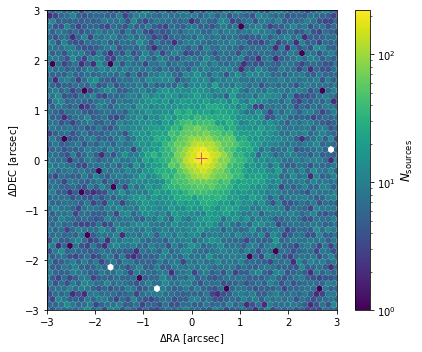

In [237]:
cos_mightee_cat = Table.read('../InputCatalogues/radio/MIGHTEE_Continuum_DR1_COSMOS_8p9arcsec_I_v1_rmsbox_mean0-2023-05-04-DoubleDetection.gaul.fits')
mightee_coords = SkyCoord(cos_mightee_cat['RA'], cos_mightee_cat['DEC'], unit='deg')

idx, d2d, d3d = cos_coord.match_to_catalog_sky(mightee_coords)

cat_match = (d2d < 1.5*u.arcsec)

# Calculate global offsets
dRA = cos_coord.ra - mightee_coords[idx].ra
dDEC = cos_coord.dec - mightee_coords[idx].dec

# Calculate median offset for likely matches
dRA_median = np.median(dRA[cat_match]).to(u.arcsec)
dDEC_median = np.median(dDEC[cat_match]).to(u.arcsec)

# Apply offset to LS DR8 coordinates 
cos_coord_offset = SkyCoord(cos_coord.ra - dRA_median, cos_coord.dec - dDEC_median)

idxcos, d2dc, d3dc = cos_coord_offset.match_to_catalog_sky(mightee_coords)
cos_match_corr = (d2dc < 1.5*u.arcsec)

Fig, Ax = plt.subplots(1,1, figsize=(6,5))

Hx = Ax.hexbin(dRA.to(u.arcsec), dDEC.to(u.arcsec), extent=[-3, 3, -3, 3], 
          bins='log', edgecolors=None, gridsize=50)
Ax.plot(dRA_median, dDEC_median, '+', color='indianred', ms=12)
Ax.set_xlim([-3, 3])
Ax.set_ylim([-3, 3])
Ax.set_xlabel(r'$\Delta \rm{RA}$ [arcsec]')
Ax.set_ylabel(r'$\Delta \rm{DEC}$ [arcsec]')
Cb = Fig.colorbar(Hx)
Cb.set_label(r'$N_{\rm{sources}}$', size=12)
Fig.tight_layout()

In [238]:
cos_data = fits.open('../InputCatalogues/radio/MIGHTEE_Continuum_DR1_COSMOS_8p9arcsec_I_v1.fits')
cos_rms = fits.open('../InputCatalogues/radio/MIGHTEE_Continuum_DR1_COSMOS_8p9arcsec_I_v1_rmsbox_mean0-2023-05-04-DoubleDetection.rms.fits')
cos_wcs = WCS(cos_data[0].header, naxis=2)

cos_img = cos_data[0].data.squeeze()
cos_rms_img = cos_rms[0].data.squeeze()

# Forced phot at initial positions
xpix, ypix = cos_wcs.world_to_array_index(cos_coord)

in_footprint = (np.logical_and(np.array(ypix) >= 0, np.array(ypix) < cos_img.shape[1]) * 
                np.logical_and(np.array(xpix) >= 0, np.array(xpix) < cos_img.shape[0]))

flux_peak_raw = cos_img[np.array(xpix)[in_footprint][:], np.array(ypix)[in_footprint][:]]
flux_rms_raw = cos_rms_img[np.array(xpix)[in_footprint][:], np.array(ypix)[in_footprint][:]]

mightee_snr_raw = np.zeros(len(wd10))
mightee_snr_raw[in_footprint] = (flux_peak_raw/flux_rms_raw)
mightee_flux_raw = np.zeros(len(wd10))
mightee_flux_raw[in_footprint] = flux_peak_raw*1e6

# Forced phot with offset applied
xpix, ypix = cos_wcs.world_to_array_index(cos_coord_offset)

in_footprint = (np.logical_and(np.array(ypix) >= 0, np.array(ypix) < cos_img.shape[1]) * 
                np.logical_and(np.array(xpix) >= 0, np.array(xpix) < cos_img.shape[0]))

flux_peak = cos_img[np.array(xpix)[in_footprint][:], np.array(ypix)[in_footprint][:]]
flux_rms = cos_rms_img[np.array(xpix)[in_footprint][:], np.array(ypix)[in_footprint][:]]

cos_mightee_snr = np.zeros(len(wd10))
cos_mightee_snr[in_footprint] = (flux_peak/flux_rms)
cos_mightee_flux = np.zeros(len(wd10))
cos_mightee_flux[in_footprint] = flux_peak*1e6

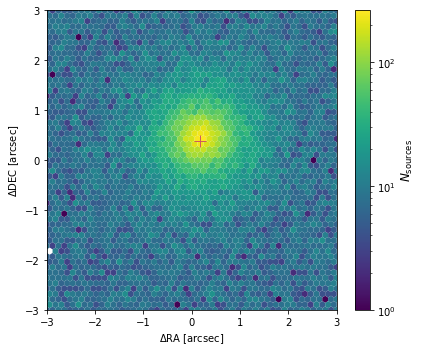

In [239]:
xmm_mightee_cat = Table.read('../InputCatalogues/radio/MIGHTEE_Continuum_DR1_XMMLSS_8p9arcsec_I_v1_rmsbox_mean0-2023-05-04-DoubleDetection.gaul.fits')
mightee_coords = SkyCoord(xmm_mightee_cat['RA'], xmm_mightee_cat['DEC'], unit='deg')

idx, d2d, d3d = xmm_coord.match_to_catalog_sky(mightee_coords)

cat_match = (d2d < 1.5*u.arcsec)

# Calculate global offsets
dRA = xmm_coord.ra - mightee_coords[idx].ra
dDEC = xmm_coord.dec - mightee_coords[idx].dec

# Calculate median offset for likely matches
dRA_median = np.median(dRA[cat_match]).to(u.arcsec)
dDEC_median = np.median(dDEC[cat_match]).to(u.arcsec)

# Apply offset to LS DR8 coordinates 
xmm_coord_offset = SkyCoord(xmm_coord.ra - dRA_median, xmm_coord.dec - dDEC_median)

idxxmm, d2dc, d3dc = xmm_coord_offset.match_to_catalog_sky(mightee_coords)
xmm_match_corr = (d2dc < 1.5*u.arcsec)

Fig, Ax = plt.subplots(1,1, figsize=(6,5))

Hx = Ax.hexbin(dRA.to(u.arcsec), dDEC.to(u.arcsec), extent=[-3, 3, -3, 3], 
          bins='log', edgecolors=None, gridsize=50)
Ax.plot(dRA_median, dDEC_median, '+', color='indianred', ms=12)
Ax.set_xlim([-3, 3])
Ax.set_ylim([-3, 3])
Ax.set_xlabel(r'$\Delta \rm{RA}$ [arcsec]')
Ax.set_ylabel(r'$\Delta \rm{DEC}$ [arcsec]')
Cb = Fig.colorbar(Hx)
Cb.set_label(r'$N_{\rm{sources}}$', size=12)
Fig.tight_layout()

In [240]:
xmm_data = fits.open('../InputCatalogues/radio/MIGHTEE_Continuum_DR1_XMMLSS_8p9arcsec_I_v1.fits')
xmm_rms = fits.open('../InputCatalogues/radio/MIGHTEE_Continuum_DR1_XMMLSS_8p9arcsec_I_v1_rmsbox_mean0-2023-05-04-DoubleDetection.rms.fits')
xmm_wcs = WCS(xmm_data[0].header, naxis=2)

xmm_img = xmm_data[0].data.squeeze()
xmm_rms_img = xmm_rms[0].data.squeeze()

# Forced phot at initial positions
xpix, ypix = xmm_wcs.world_to_array_index(xmm_coord)

in_footprint = (np.logical_and(np.array(ypix) >= 0, np.array(ypix) < xmm_img.shape[1]) * 
                np.logical_and(np.array(xpix) >= 0, np.array(xpix) < xmm_img.shape[0]))

flux_peak_raw = xmm_img[np.array(xpix)[in_footprint][:], np.array(ypix)[in_footprint][:]]
flux_rms_raw = xmm_rms_img[np.array(xpix)[in_footprint][:], np.array(ypix)[in_footprint][:]]

mightee_snr_raw = np.zeros(len(wd02))
mightee_snr_raw[in_footprint] = (flux_peak_raw/flux_rms_raw)
mightee_flux_raw = np.zeros(len(wd02))
mightee_flux_raw[in_footprint] = flux_peak_raw*1e6

# Forced phot with offset applied
xpix, ypix = xmm_wcs.world_to_array_index(xmm_coord_offset)

in_footprint = (np.logical_and(np.array(ypix) >= 0, np.array(ypix) < xmm_img.shape[1]) * 
                np.logical_and(np.array(xpix) >= 0, np.array(xpix) < xmm_img.shape[0]))

flux_peak = xmm_img[np.array(xpix)[in_footprint][:], np.array(ypix)[in_footprint][:]]
flux_rms = xmm_rms_img[np.array(xpix)[in_footprint][:], np.array(ypix)[in_footprint][:]]

xmm_mightee_snr = np.zeros(len(wd02))
xmm_mightee_snr[in_footprint] = (flux_peak/flux_rms)
xmm_mightee_flux = np.zeros(len(wd02))
xmm_mightee_flux[in_footprint] = flux_peak*1e6

Centre of field:  53.386 deg -27.739 deg
dRA=0.199 arcsec dDEC=0.101 arcsec


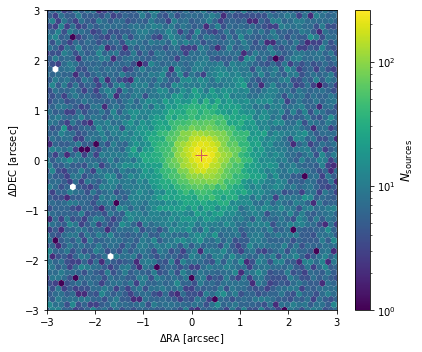

In [241]:
cdfs_mightee_cat = Table.read('../InputCatalogues/radio/MIGHTEE_CDFS_x25_020424_rmsbox_mean0-2024-04-11-DoubleDetection.srl.fits')
mightee_coords = SkyCoord(cdfs_mightee_cat['RA'], cdfs_mightee_cat['DEC'], unit='deg')

print(f"Centre of field: {np.median(mightee_coords.ra): .3f} {np.median(mightee_coords.dec): .3f}")

idx, d2d, d3d = cdfs_coord.match_to_catalog_sky(mightee_coords)

cat_match = (d2d < 1.5*u.arcsec)

# Calculate global offsets
dRA = cdfs_coord.ra - mightee_coords[idx].ra
dDEC = cdfs_coord.dec - mightee_coords[idx].dec

# Calculate median offset for likely matches
dRA_median = np.median(dRA[cat_match]).to(u.arcsec)
dDEC_median = np.median(dDEC[cat_match]).to(u.arcsec)

print(f'dRA={dRA_median:.3f} dDEC={dDEC_median:.3f}')

# Apply offset to LS DR8 coordinates 
cdfs_coord_offset = SkyCoord(cdfs_coord.ra - dRA_median, cdfs_coord.dec - dDEC_median)

idxcdfs, d2dc, d3dc = cdfs_coord_offset.match_to_catalog_sky(mightee_coords)
cdfs_match_corr = (d2dc < 1.5*u.arcsec)

Fig, Ax = plt.subplots(1,1, figsize=(6,5))

Hx = Ax.hexbin(dRA.to(u.arcsec), dDEC.to(u.arcsec), extent=[-3, 3, -3, 3], 
          bins='log', edgecolors=None, gridsize=50)
Ax.plot(dRA_median, dDEC_median, '+', color='indianred', ms=12)
Ax.set_xlim([-3, 3])
Ax.set_ylim([-3, 3])
Ax.set_xlabel(r'$\Delta \rm{RA}$ [arcsec]')
Ax.set_ylabel(r'$\Delta \rm{DEC}$ [arcsec]')
Cb = Fig.colorbar(Hx)
Cb.set_label(r'$N_{\rm{sources}}$', size=12)
Fig.tight_layout()

In [242]:
cdfs_data = fits.open('../InputCatalogues/radio/MIGHTEE_CDFS_x25_020424.fits')
cdfs_rms = fits.open('../InputCatalogues/radio/MIGHTEE_CDFS_x25_020424_rmsbox_mean0-2024-04-11-DoubleDetection.rms.fits')
cdfs_wcs = WCS(cdfs_data[0].header, naxis=2)

cdfs_img = cdfs_data[0].data.squeeze()
cdfs_rms_img = cdfs_rms[0].data.squeeze()

# Forced phot at initial positions
xpix, ypix = cdfs_wcs.world_to_array_index(cdfs_coord)

in_footprint = (np.logical_and(np.array(ypix) >= 0, np.array(ypix) < cdfs_img.shape[1]) * 
                np.logical_and(np.array(xpix) >= 0, np.array(xpix) < cdfs_img.shape[0]))

flux_peak_raw = cdfs_img[np.array(xpix)[in_footprint][:], np.array(ypix)[in_footprint][:]]
flux_rms_raw = cdfs_rms_img[np.array(xpix)[in_footprint][:], np.array(ypix)[in_footprint][:]]

mightee_snr_raw = np.zeros(len(wd03))
mightee_snr_raw[in_footprint] = (flux_peak_raw/flux_rms_raw)
mightee_flux_raw = np.zeros(len(wd03))
mightee_flux_raw[in_footprint] = flux_peak_raw*1e6

# Forced phot with offset applied
xpix, ypix = cdfs_wcs.world_to_array_index(cdfs_coord_offset)

in_footprint = (np.logical_and(np.array(ypix) >= 0, np.array(ypix) < cdfs_img.shape[1]) * 
                np.logical_and(np.array(xpix) >= 0, np.array(xpix) < cdfs_img.shape[0]))

flux_peak = cdfs_img[np.array(xpix)[in_footprint][:], np.array(ypix)[in_footprint][:]]
flux_rms = cdfs_rms_img[np.array(xpix)[in_footprint][:], np.array(ypix)[in_footprint][:]]

cdfs_mightee_snr = np.zeros(len(wd03))
cdfs_mightee_snr[in_footprint] = (flux_peak/flux_rms)
cdfs_mightee_flux = np.zeros(len(wd03))
cdfs_mightee_flux[in_footprint] = flux_peak*1e6

Centre of field:  53.124 deg -28.136 deg
dRA=0.178 arcsec dDEC=0.199 arcsec


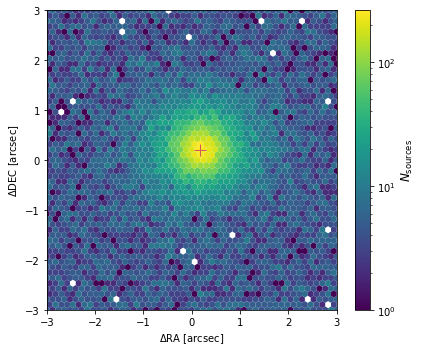

In [243]:
cdfs_deep_cat = Table.read('../InputCatalogues/radio/MIGHTEE_Continuum_DR1_CDFS-DEEP_5p5arcsec_I_v1_rmsbox_mean0-2023-05-04-DoubleDetection.gaul.fits')
mightee_deep_coords = SkyCoord(cdfs_deep_cat['RA'], cdfs_deep_cat['DEC'], unit='deg')

print(f"Centre of field: {np.median(mightee_deep_coords.ra): .3f} {np.median(mightee_deep_coords.dec): .3f}")

idx, d2d, d3d = cdfs_coord.match_to_catalog_sky(mightee_deep_coords)

cat_match_deep = (d2d < 1.5*u.arcsec)

# Calculate global offsets
dRA_deep = cdfs_coord.ra - mightee_deep_coords[idx].ra
dDEC_deep = cdfs_coord.dec - mightee_deep_coords[idx].dec

# Calculate median offset for likely matches
dRA_median_deep = np.median(dRA_deep[cat_match_deep]).to(u.arcsec)
dDEC_median_deep = np.median(dDEC_deep[cat_match_deep]).to(u.arcsec)

print(f'dRA={dRA_median_deep:.3f} dDEC={dDEC_median_deep:.3f}')

# Apply offset to LS DR8 coordinates 
cdfs_coord_offset_deep = SkyCoord(cdfs_coord.ra - dRA_median_deep, cdfs_coord.dec - dDEC_median_deep)

idxc_deep, d2dc, d3dc = cdfs_coord_offset_deep.match_to_catalog_sky(mightee_deep_coords)
cdfs_match_corr_deep = (d2dc < 1.5*u.arcsec)

Fig, Ax = plt.subplots(1,1, figsize=(6,5))

Hx = Ax.hexbin(dRA_deep.to(u.arcsec), dDEC_deep.to(u.arcsec), extent=[-3, 3, -3, 3], 
          bins='log', edgecolors=None, gridsize=50)
Ax.plot(dRA_median_deep, dDEC_median_deep, '+', color='indianred', ms=12)
Ax.set_xlim([-3, 3])
Ax.set_ylim([-3, 3])
Ax.set_xlabel(r'$\Delta \rm{RA}$ [arcsec]')
Ax.set_ylabel(r'$\Delta \rm{DEC}$ [arcsec]')
Cb = Fig.colorbar(Hx)
Cb.set_label(r'$N_{\rm{sources}}$', size=12)
Fig.tight_layout()


In [244]:
cdfs_deep_data = fits.open('../InputCatalogues/radio/MIGHTEE_Continuum_DR1_CDFS-DEEP_5p5arcsec_I_v1.fits')
cdfs_deep_rms = fits.open('../InputCatalogues/radio/MIGHTEE_Continuum_DR1_CDFS-DEEP_5p5arcsec_I_v1_rmsbox_mean0-2023-05-04-DoubleDetection.rms.fits')
cdfs_deep_wcs = WCS(cdfs_deep_data[0].header, naxis=2)

cdfs_deep_img = cdfs_deep_data[0].data.squeeze()
cdfs_deep_rms_img = cdfs_deep_rms[0].data.squeeze()

# Forced phot at initial positions
xpix, ypix = cdfs_deep_wcs.world_to_array_index(cdfs_coord)

in_footprint = (np.logical_and(np.array(ypix) >= 0, np.array(ypix) < cdfs_deep_img.shape[1]) * 
                np.logical_and(np.array(xpix) >= 0, np.array(xpix) < cdfs_deep_img.shape[0]))

flux_peak_raw = cdfs_deep_img[np.array(xpix)[in_footprint][:], np.array(ypix)[in_footprint][:]]
flux_rms_raw = cdfs_deep_rms_img[np.array(xpix)[in_footprint][:], np.array(ypix)[in_footprint][:]]

mightee_snr_raw = np.zeros(len(wd03))
mightee_snr_raw[in_footprint] = (flux_peak_raw/flux_rms_raw)
mightee_flux_raw = np.zeros(len(wd03))
mightee_flux_raw[in_footprint] = flux_peak_raw*1e6

# Forced phot with offset applied
xpix, ypix = cdfs_deep_wcs.world_to_array_index(cdfs_coord_offset)

in_footprint = (np.logical_and(np.array(ypix) >= 0, np.array(ypix) < cdfs_deep_img.shape[1]) * 
                np.logical_and(np.array(xpix) >= 0, np.array(xpix) < cdfs_deep_img.shape[0]))

flux_peak = cdfs_deep_img[np.array(xpix)[in_footprint][:], np.array(ypix)[in_footprint][:]]
flux_rms = cdfs_deep_rms_img[np.array(xpix)[in_footprint][:], np.array(ypix)[in_footprint][:]]

cdfs_mightee_deep_snr = np.zeros(len(wd03))
cdfs_mightee_deep_snr[in_footprint] = (flux_peak/flux_rms)
cdfs_mightee_deep_flux = np.zeros(len(wd03))
cdfs_mightee_deep_flux[in_footprint] = flux_peak*1e6

## Selection Criteria

Here we set the various selection criteria for the DDF Deep samples. The variables to play with: 
- Radio: Flux density threshold `radio_flux_cut`, and the radio SNR threshold `radio_snr_cut`
- Optical: Magnitude column choice `mag_col` and the corresponding magnitude limit `maglim`
- Photo-$z$: The redshift probability cut `pcut` (the fraction of redshift probability below $z=1.4$

In [334]:
radio_flux_cut = 15
radio_snr_cut = 3
maglim = 22.8
mag_col = 'mag_Zt'
pcut = 0.8

## Resulting Samples

In [335]:
### XMM

wd02_zcut = (wd02['P140_gpz'] > pcut) * np.isfinite(wd02['P140_gpz'])

xmm_forced = (xmm_mightee_snr > radio_snr_cut)*(xmm_mightee_flux > radio_flux_cut)
xmm_catalogue = xmm_match_corr * (xmm_mightee_cat['Total_flux'][idxxmm]*1e6 > radio_flux_cut)
xmm_selection = np.logical_or(xmm_forced, xmm_catalogue)

print(f"MIGHTEE XMM-LSS Catalogue Gaussians not picked up in forced photometry: {(xmm_catalogue * np.invert(xmm_forced) * wd02_zcut).sum()}" )
print(f"MIGHTEE XMM-LSS Forced photometry sources not in PyBDSF catalogue: {(xmm_forced * np.invert(xmm_match_corr) * wd02_zcut).sum()}" )

xmm_non_duplicate = np.invert(np.isnan(wd02_etcm['TEXP_D'].filled(np.nan)))

xmm_orchidss_selection = (xmm_selection * xmm_non_duplicate * 
                          (wd02[mag_col] < maglim) * wd02_zcut).filled(False)

print(f"Total sample: {xmm_orchidss_selection.sum()}\n")

### CDFS

wd03_zcut = (wd03['P140_gpz'] > pcut) * np.isfinite(wd03['P140_gpz'])

cdfs_forced = (cdfs_mightee_snr > radio_snr_cut)*(cdfs_mightee_flux > radio_flux_cut)
cdfs_catalogue = cdfs_match_corr * (cdfs_mightee_cat['Total_flux'][idxcdfs]*1e6 > radio_flux_cut)
cdfs_selection = np.logical_or(cdfs_forced, cdfs_catalogue)

print(f"MIGHTEE ECDFS Catalogue Gaussians not picked up in forced photometry: {(cdfs_catalogue * np.invert(cdfs_forced) * wd03_zcut).sum()}" )
print(f"MIGHTEE ECDFS Forced photometry sources not in PyBDSF catalogue: {(cdfs_forced * np.invert(cdfs_match_corr) * wd03_zcut).sum()}\n" )

cdfs_deep_forced = (cdfs_mightee_deep_snr > radio_snr_cut)*(cdfs_mightee_deep_flux > radio_flux_cut)
cdfs_deep_catalogue = cdfs_match_corr_deep * (cdfs_deep_cat['Total_flux'][idxc_deep]*1e6 > radio_flux_cut)
cdfs_deep_selection = np.logical_or(cdfs_deep_forced, cdfs_deep_catalogue)

print(f"MIGHTEE ECDFS Deep Catalogue Gaussians not picked up in forced photometry: {(cdfs_deep_catalogue * np.invert(cdfs_deep_forced) * wd03_zcut).sum()}" )
print(f"MIGHTEE ECDFS Deep Forced photometry sources not in PyBDSF catalogue: {(cdfs_deep_forced * np.invert(cdfs_match_corr_deep) * wd03_zcut).sum()}" )

cdfs_non_duplicate = np.invert(np.isnan(wd03_etcm['TEXP_D'].filled(np.nan)))

cdfs_orchidss_selection = (np.logical_or(cdfs_selection, cdfs_deep_selection) * cdfs_non_duplicate * 
                           (wd03[mag_col] < maglim) *  wd03_zcut).filled(False)

print(f"Total sample: {cdfs_orchidss_selection.sum()}\n\n")

### COSMOS

cos_forced = (cos_mightee_snr > radio_snr_cut)*(cos_mightee_flux > radio_flux_cut)
cos_catalogue = cos_match_corr * (cos_mightee_cat['Total_flux'][idxcos]*1e6 > radio_flux_cut)
cos_selection = np.logical_or(cos_forced, cos_catalogue)

wd10_zcut = (wd10['P140_gpz'] > pcut) * np.isfinite(wd10['P140_gpz'])

print(f"MIGHTEE COSMOS Catalogue Gaussians not picked up in forced photometry: {(cos_catalogue * np.invert(cos_forced) * wd10_zcut).sum()}" )
print(f"MIGHTEE COSMOS Forced photometry sources not in PyBDSF catalogue: {(cos_forced * np.invert(cos_match_corr) * wd10_zcut).sum()}" )

cos_non_duplicate = np.invert(np.isnan(wd10_etcm['TEXP_D'].filled(np.nan)))

cos_orchidss_selection = (cos_selection * cos_non_duplicate * (wd10[mag_col] < maglim) * wd10_zcut).filled(False)

print(f"Total sample: {cos_orchidss_selection.sum()}\n")

wd02moc = MOC.from_skycoords(xmm_coord, max_norder=12)
wd02_area = (wd02moc.sky_fraction*4*np.pi*u.steradian).to(u.deg**2)

print(f"WD02/XMM-LSS: {xmm_orchidss_selection.sum()/wd02_area:.0f}")

wd03moc = MOC.from_skycoords(cdfs_coord, max_norder=12)
wd03_area = (wd03moc.sky_fraction*4*np.pi*u.steradian).to(u.deg**2)

print(f"WD03/CDFS: {cdfs_orchidss_selection.sum()/wd03_area:.0f}")

dmoc = MOC.from_skycoords(cos_coord[(cos_mightee_snr>0)], max_norder=12)
wd10_area = (dmoc.sky_fraction*4*np.pi*u.steradian).to(u.deg**2)

print(f"WD10/COSMOS: {cos_orchidss_selection.sum()/wd10_area:.0f}")

MIGHTEE XMM-LSS Catalogue Gaussians not picked up in forced photometry: 376
MIGHTEE XMM-LSS Forced photometry sources not in PyBDSF catalogue: 21649
Total sample: 30118

MIGHTEE ECDFS Catalogue Gaussians not picked up in forced photometry: 339
MIGHTEE ECDFS Forced photometry sources not in PyBDSF catalogue: 14079

MIGHTEE ECDFS Deep Catalogue Gaussians not picked up in forced photometry: 1214
MIGHTEE ECDFS Deep Forced photometry sources not in PyBDSF catalogue: 2786
Total sample: 28387


MIGHTEE COSMOS Catalogue Gaussians not picked up in forced photometry: 292
MIGHTEE COSMOS Forced photometry sources not in PyBDSF catalogue: 20161
Total sample: 27701

WD02/XMM-LSS: 7141 1 / deg2
WD03/CDFS: 6720 1 / deg2
WD10/COSMOS: 7005 1 / deg2


## Validation Plots

Firstly, lets just plot the spatial distributions to check for weird structures/inhomogeneities/area issues:

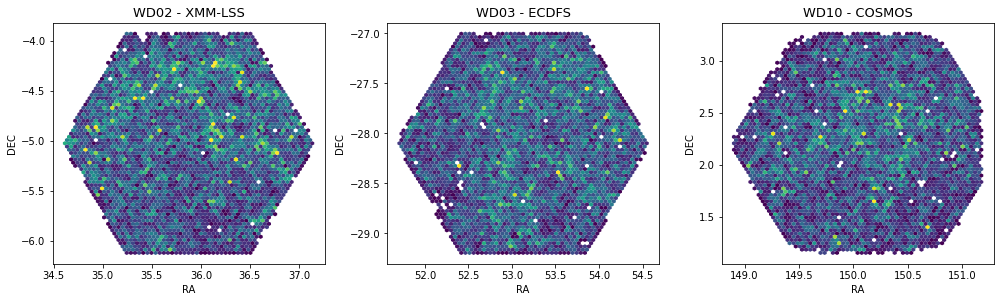

In [336]:
Fig, Ax = plt.subplots(1, 3, figsize=(14, 4.3))

Ax[0].hexbin(wd02['RAGAIA_r'][xmm_orchidss_selection], 
           wd02['DecGAIA_r'][xmm_orchidss_selection], gridsize=60, edgecolors=None, mincnt=1, vmax=30)
Ax[1].hexbin(wd03['RAGAIA_r'][cdfs_orchidss_selection], 
           wd03['DecGAIA_r'][cdfs_orchidss_selection], gridsize=60, edgecolors=None, mincnt=1, vmax=30)
Ax[2].hexbin(wd10['RAGAIA_r'][cos_orchidss_selection], 
           wd10['DecGAIA_r'][cos_orchidss_selection], gridsize=60, edgecolors=None, mincnt=1, vmax=30)

fields = ['WD02 - XMM-LSS', 'WD03 - ECDFS', 'WD10 - COSMOS']

for i, ax in enumerate(Ax):
    ax.set_aspect('auto')
    ax.set_title(fields[i], size=13)
    ax.set_xlabel('RA')
    ax.set_ylabel('DEC')

Fig.tight_layout()
Fig.savefig('Figures/ddf_radec_density.pdf', format='pdf')

## Redshift Threshold Optimisation

Next (although this is slightly circular), we will use alternative deep photo-$z$ catalogues as references to assess the photometric redshift selection and optimise that threshold given the radio and magnitude cuts.
To do this we employ three external alternative photo-$z$ catalogues:

- COSMOS: COSMOS 2020 (Weaver et al.) - Specifically the Farmer photometry and Eazy photometric redshift
- XMM-LSS: VIDEO Internal (Hybrid?) photo-z estimates using HSC etc.
- CDFS: Video Internal template based photo-z estimates (LePhare)

In all three cases, the optical photometry is substantially deeper than the DDF imaging in most cases, while also Spitzer etc. are included. So while not a full spectroscopic sample, they will be 

For the overlap of optical sources _that meet the MIGHTEE radio flux/SNR and optical magnitude limits_, we vary the GPz photo-z selection threshold and calculate what fraction of the selected sources have deep photo-$z$ estimates at $z > 1.4$ (i.e. are contaminants) as well as what fraction of 'true' $z < 1.4$ (based on the deep photo-zs) sources are selected.

In [337]:
## COSMOS Validation
c2020 = Table.read('../InputCatalogues/photoz/COSMOS2020_FARMER_R1_v2.0_cut.fits')

c2020_coord = SkyCoord(c2020['ALPHA_J2000'], c2020['DELTA_J2000'], unit='deg')
idx, d2d, d3d = cos_coord.match_to_catalog_sky(c2020_coord)

match = (d2d < 0.4*u.arcsec)

c2020_zp1 = np.ones(len(wd10)) * np.nan
c2020_zp2 = np.ones(len(wd10)) * np.nan

c2020_zp1[match] = c2020['lp_zPDF'][idx[match]] # LePhare
c2020_zp2[match] = c2020['ez_z_phot'][idx[match]] # Eazy

c2020_zplim = np.ones(len(wd10)) * np.nan
c2020_zplim[match] = c2020['ez_z840'][idx[match]]

has_z1 = np.isreal(c2020_zp1)
has_z2 = np.isreal(c2020_zp2)

c2020_moc = MOC.from_skycoords(cos_coord[match*has_z1], max_norder=12)
c2020_area = (c2020_moc.sky_fraction * 4 * np.pi * u.steradian).to(u.deg**2)


ccuts = 1-np.logspace(-3, 0, 100)
cos_purity = np.zeros_like(ccuts)
cos_completeness = np.zeros_like(ccuts)
cos_sample_size = np.zeros_like(ccuts)

for i, c in enumerate(ccuts):
    zc = (wd10['P140_gpz'] > c)

    parent = match * has_z1 * cos_selection * (wd10[mag_col] < maglim) * (c2020_zp2 > 0.)
    s = zc * parent
    cos_purity[i] = 1 - (s * (c2020_zp2 > 1.4)).sum() / (s.sum())
    
    cos_sample_size[i] = s.sum() / c2020_area.value
    cos_completeness[i] = (s*(c2020_zp2 < 1.4)).sum() / ((c2020_zp2 < 1.4)*parent).sum()


### XMM Validation
xmm_pz = Table.read('../InputCatalogues/photoz/XMMFULL_DR2_MASKVISTA_Ks_2.0as_IRAC2.8as_2021_03_09_Spec_photz2021_v5.fits')
xmm_pz.keep_columns(['RA', 'DEC', 'XMM_phot_z', 'XMM_phot_z_uncertainty'])

xmm_pz_coord = SkyCoord(xmm_pz['RA'], xmm_pz['DEC'], unit='deg')
idx, d2d, d3d = xmm_coord.match_to_catalog_sky(xmm_pz_coord)

match = (d2d < 0.4*u.arcsec)

xmm_zp = np.ones(len(wd02)) * np.nan
xmm_zp[match] = xmm_pz['XMM_phot_z'][idx[match]]

xmm_pz_moc = MOC.from_skycoords(xmm_coord[match], max_norder=12)
xmm_pz_area = (xmm_pz_moc.sky_fraction * 4 * np.pi * u.steradian).to(u.deg**2)

ccuts = 1-np.logspace(-3, 0, 100)
xmm_purity = np.zeros_like(ccuts)
xmm_completeness = np.zeros_like(ccuts)
xmm_sample_size = np.zeros_like(ccuts)

for i, c in enumerate(ccuts):
    zc = (wd02['P140_gpz'] > c)

    parent = match * xmm_selection * (wd02[mag_col] < maglim) * (xmm_zp > 0.)
    s = zc * parent
    xmm_purity[i] = 1 - (s * (xmm_zp > 1.4)).sum() / (s.sum())
    
    xmm_sample_size[i] = s.sum() / xmm_pz_area.value
    xmm_completeness[i] = (s*(xmm_zp < 1.4)).sum() / ((xmm_zp < 1.4)*parent).sum()

    
### CDFS Validation
cdfs_pz = Table.read('../InputCatalogues/photoz/CDFSFULL_DR2_MASKVISTA_Ks_2.0as_IRAC2.8as_2021_07_19_LePhareBC03_v2.fits')
cdfs_pz.keep_columns(['RA', 'DEC', 'Z_Phot', 'Z_Phot_Sp'])

cdfs_pz_coord = SkyCoord(cdfs_pz['RA'], cdfs_pz['DEC'], unit='deg')
idx, d2d, d3d = cdfs_coord.match_to_catalog_sky(cdfs_pz_coord)

match = (d2d < 0.4*u.arcsec)

cdfs_zp = np.ones(len(wd03)) * np.nan
cdfs_zp[match] = cdfs_pz['Z_Phot'][idx[match]]

cdfs_pz_moc = MOC.from_skycoords(cdfs_coord[match], max_norder=12)
cdfs_pz_area = (cdfs_pz_moc.sky_fraction * 4 * np.pi * u.steradian).to(u.deg**2)

ccuts = 1-np.logspace(-3, 0, 100)
cdfs_purity = np.zeros_like(ccuts)
cdfs_completeness = np.zeros_like(ccuts)
cdfs_sample_size = np.zeros_like(ccuts)

for i, c in enumerate(ccuts):
    zc = (wd03['P140_gpz'] > c)

    parent = match * cdfs_selection * (wd03[mag_col] < maglim) * (cdfs_zp > 0.)
    s = zc * parent
    cdfs_purity[i] = 1 - (s * (cdfs_zp > 1.4)).sum() / (s.sum())
    
    cdfs_sample_size[i] = s.sum() / cdfs_pz_area.value
    cdfs_completeness[i] = (s*(cdfs_zp < 1.4)).sum() / ((cdfs_zp < 1.4)*parent).sum()

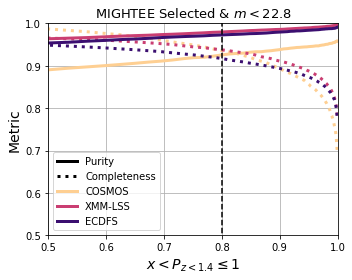

In [338]:
Fig, Ax = plt.subplots(1,1, figsize=(5, 4))

cols = plt.cm.magma_r(np.linspace(0.1, 0.8, 3))

#Tw = Ax.twinx()
Ax.plot(-1, -1, 'k', lw=3, label='Purity')
Ax.plot(-1, -1, 'k:', lw=3, label='Completeness')

Ax.plot(ccuts, cos_purity, color=cols[0], lw=3, label='COSMOS')
Ax.plot(ccuts, cos_completeness, color=cols[0], ls=':', lw=3)
Ax.plot(ccuts, xmm_purity, color=cols[1], lw=3, label='XMM-LSS')
Ax.plot(ccuts, xmm_completeness, color=cols[1], lw=3, ls=':')
Ax.plot(ccuts, cdfs_purity, color=cols[2], lw=3, label='ECDFS')
Ax.plot(ccuts, cdfs_completeness, color=cols[2], lw=3, ls=':')

Ax.set_xlim([0.5, 1.0])
Ax.set_ylim([0.5, 1.0])
#Ax.plot([0, 1], [0.85, 0.85], 'k--', alpha=0.5)
Ax.grid()
Ax.plot([pcut, pcut], [0., 1.0], 'k--')
Ax.set_xlabel('$x < P_{z<1.4} \leq 1$', size=14)
Ax.set_ylabel('Metric', size=14)
Ax.set_title(f'MIGHTEE Selected & $m < {maglim}$', size=13)
Leg = Ax.legend(loc='lower left')

Fig.tight_layout()
Fig.savefig(f'Figures/ddf_purity_completeness_Z{maglim}_P140.pdf', format='pdf')

## Scope of Survey (ETC) checks


The total estimated SoS is defined as the total of the ETC requirements per target clipped at the minimum (SB defined) and maximum (survey defined) exposure times, multiplied by the required completeness to achieve a FoM = 0.5, which is 0.85 in the case of ORCHIDSS:

In [327]:
wide_ddf_etc = Table.read('../InputCatalogues/etc_outputs/ORCHIDSSwideDDF_forETC_nosharedtargets_correct_output_ETC2024-05-20_08 29 42.fits')
wide_mfs_etc = Table.read('../InputCatalogues/etc_outputs/ORCHIDSSwideMFS_forETC_nosharedtargets_correct_output_ETC2024-05-20_08 20 48.fits')

tmin = [21, 16.86, 7.86]
tmax_deep = [420, 532, 935]
tmax_wide = [180, 225, 384]

from astropy.table import vstack
wd_deep_etc = vstack([wd02_etcm[xmm_orchidss_selection],
                      wd03_etcm[cdfs_orchidss_selection],
                      wd10_etcm[cos_orchidss_selection]])

for i, sb in enumerate(['Dark', 'Gray', 'Bright']):

    print(f"{sb} time:")
    wide_ddf_sos = np.clip(wide_ddf_etc[f'TEXP_{sb[0]}'], tmin[i], tmax_wide[i]).sum() / 60
    wide_mfs_sos = np.clip(wide_mfs_etc[f'TEXP_{sb[0]}'], tmin[i], tmax_wide[i]).sum() / 60

    wd02_sos = np.clip(wd02_etcm[f'TEXP_{sb[0]}'][xmm_orchidss_selection], tmin[i], tmax_deep[i]).sum() / 60
    wd03_sos = np.clip(wd03_etcm[f'TEXP_{sb[0]}'][cdfs_orchidss_selection], tmin[i], tmax_deep[i]).sum() / 60
    wd10_sos = np.clip(wd10_etcm[f'TEXP_{sb[0]}'][cos_orchidss_selection], tmin[i], tmax_deep[i]).sum() / 60

    n_deep = len(wd_deep_etc)
    n_wide = len(wide_ddf_etc)+len(wide_mfs_etc)
    
    print(f"Deep SoS (N={n_deep}): {(wd02_sos + wd03_sos + wd10_sos)*0.85:.0f} fhr")
    print(f"Wide SoS (N={n_wide}): {(wide_ddf_sos + wide_mfs_sos)*0.85:.0f} fhr")

    total_sos = np.around(wd02_sos + wd03_sos + wd10_sos + wide_ddf_sos + wide_mfs_sos, 0)
    
    print(f"Total estimated SoS {0.85 * total_sos:.0f} fhr (excluding shared targets)\n")

Dark time:
Deep SoS (N=82375): 118219 fhr
Wide SoS (N=88634): 45807 fhr
Total estimated SoS 164026 fhr (excluding shared targets)

Gray time:
Deep SoS (N=82375): 144537 fhr
Wide SoS (N=88634): 49309 fhr
Total estimated SoS 193846 fhr (excluding shared targets)

Bright time:
Deep SoS (N=82375): 244477 fhr
Wide SoS (N=88634): 70950 fhr
Total estimated SoS 315427 fhr (excluding shared targets)



Dark time:
Deep SoS (N=84234): 125522 fhr
Wide SoS (N=88634): 45807 fhr
Total estimated SoS 171330 fhr (excluding shared targets)

Gray time:
Deep SoS (N=84234): 153722 fhr
Wide SoS (N=88634): 49309 fhr
Total estimated SoS 203030 fhr (excluding shared targets)

Bright time:
Deep SoS (N=84234): 260445 fhr
Wide SoS (N=88634): 70950 fhr
Total estimated SoS 331395 fhr (excluding shared targets)

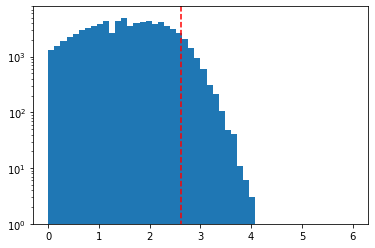

In [328]:
plt.hist(np.log10(wd_deep_etc['TEXP_D']), range=(0, 6), bins=50)
plt.vlines(np.log10(420), 8000, 0.1, color='r', ls='--')
plt.ylim([1, 8000])
plt.yscale('log')

# Additional ETC Checks

### How do the Deep (WAVES) and Wide (Legacy DR8) derived ETC calculations compare?

Shared targets between the sub-surveys are defined in 4MOST as within a radius of 0.4". In these cases the fhr's will be shared between all sub-surveys according to the various time requests. Within WAVES the ultimate cut-off will be meeting the threshold for a robust spectroscopic redshift, which will be consistent across the board. ORCHIDSS' request from each subsurvey will be the same, however SoS calculations approximate this based on the S7 simulations of the template set. Given the different optical photometry and template assignments between Wide DDF and Deep, we want to check how consistent they currently are:

In [340]:
wide_ddf_coord = SkyCoord(wide_ddf_etc['RA'], wide_ddf_etc['DEC'], unit='deg')
idzcos, d2dcos, d3dcos = wide_ddf_coord.match_to_catalog_sky(cos_coord[cos_orchidss_selection])
ddf_wide_cos_match = (d2dcos < 0.4*u.arcsec)

idzxmm, d2dxmm, d3dxmm = wide_ddf_coord.match_to_catalog_sky(xmm_coord[xmm_orchidss_selection])
ddf_wide_xmm_match = (d2dxmm < 0.4*u.arcsec)

idzcdfs, d2dcdfs, d3dcdfs = wide_ddf_coord.match_to_catalog_sky(cdfs_coord[cdfs_orchidss_selection])
ddf_wide_cdfs_match = (d2dcdfs < 0.4*u.arcsec)

In [217]:
# etc_waves = Table.from_pandas(pd.read_parquet('../InputCatalogues/photoz/WD10_Photoz_Combined_ETC_c_Sabine Bellstedt.parquet'))
# etc_join = join(wd10_etcm, etc_waves, keys='uberID', join_type='left')

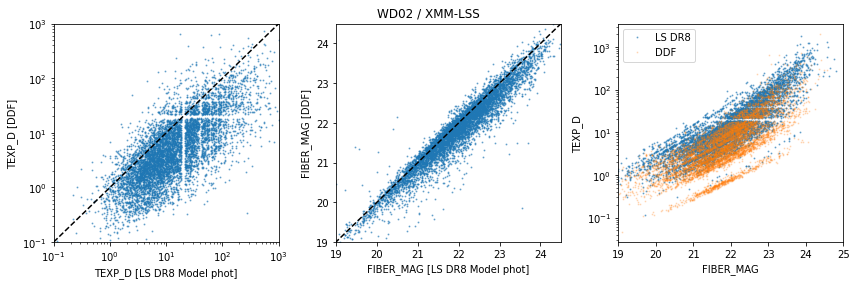

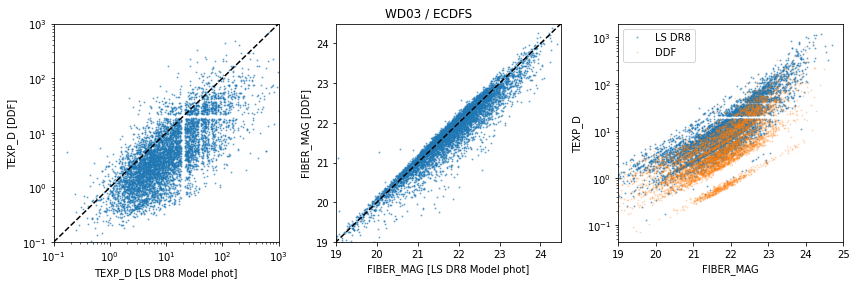

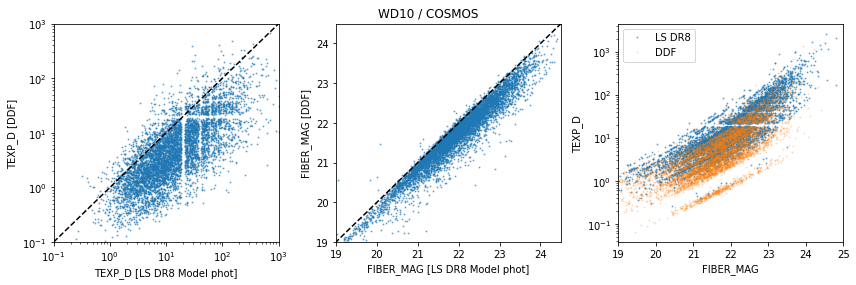

In [341]:
### XMM-LSS ###
Fig, Ax = plt.subplots(1, 3, figsize=(12, 4))
Ax[0].loglog(wide_ddf_etc['TEXP_D'][ddf_wide_xmm_match], 
             wd02_etcm['TEXP_D'][xmm_orchidss_selection][idzxmm[ddf_wide_xmm_match]], 
             'o', ms=1, alpha=0.5)

Ax[0].plot([1e-1, 1e3], [1e-1, 1e3], 'k--')
Ax[0].set_xlim([1e-1, 1e3])
Ax[0].set_ylim([1e-1, 1e3])
Ax[0].set_xlabel('TEXP_D [LS DR8 Model phot]')
Ax[0].set_ylabel('TEXP_D [DDF]')

Ax[1].plot(wide_ddf_etc['FIBER_MAG'][ddf_wide_xmm_match], 
           wd02_etcm['FIBER_MAG'][xmm_orchidss_selection][idzxmm[ddf_wide_xmm_match]], 
           'o', ms=1, alpha=0.5)

Ax[1].plot([18,25], [18, 25], 'k--')
Ax[1].set_xlabel('FIBER_MAG [LS DR8 Model phot]')
Ax[1].set_ylabel('FIBER_MAG [DDF]')

Ax[1].set_xlim([19, 24.5])
Ax[1].set_ylim([19, 24.5])

Ax[2].semilogy(wide_ddf_etc['FIBER_MAG'][ddf_wide_xmm_match], 
               wide_ddf_etc['TEXP_D'][ddf_wide_xmm_match], 
               'o', ms=1, alpha=0.5, label='LS DR8')

Ax[2].semilogy(wd02_etcm['FIBER_MAG'][xmm_orchidss_selection][idzxmm[ddf_wide_xmm_match]], 
               wd02_etcm['TEXP_D'][xmm_orchidss_selection][idzxmm[ddf_wide_xmm_match]],
               'o', ms=1, alpha=0.2, label='DDF')

Leg = Ax[2].legend(loc='upper left')
Ax[2].set_xlabel('FIBER_MAG')
Ax[2].set_ylabel('TEXP_D')
Ax[2].set_xlim([19, 25])
Fig.suptitle('WD02 / XMM-LSS')
Fig.tight_layout()
Fig.subplots_adjust(top=0.92)

### ECDFS ###
Fig, Ax = plt.subplots(1, 3, figsize=(12, 4))
Ax[0].loglog(wide_ddf_etc['TEXP_D'][ddf_wide_cdfs_match], 
             wd03_etcm['TEXP_D'][cdfs_orchidss_selection][idzcdfs[ddf_wide_cdfs_match]], 
             'o', ms=1, alpha=0.5)

Ax[0].plot([1e-1, 1e3], [1e-1, 1e3], 'k--')
Ax[0].set_xlim([1e-1, 1e3])
Ax[0].set_ylim([1e-1, 1e3])
Ax[0].set_xlabel('TEXP_D [LS DR8 Model phot]')
Ax[0].set_ylabel('TEXP_D [DDF]')

Ax[1].plot(wide_ddf_etc['FIBER_MAG'][ddf_wide_cdfs_match], 
           wd03_etcm['FIBER_MAG'][cdfs_orchidss_selection][idzcdfs[ddf_wide_cdfs_match]], 
           'o', ms=1, alpha=0.5)

Ax[1].plot([18,25], [18, 25], 'k--')
Ax[1].set_xlabel('FIBER_MAG [LS DR8 Model phot]')
Ax[1].set_ylabel('FIBER_MAG [DDF]')

Ax[1].set_xlim([19, 24.5])
Ax[1].set_ylim([19, 24.5])

Ax[2].semilogy(wide_ddf_etc['FIBER_MAG'][ddf_wide_cdfs_match], 
               wide_ddf_etc['TEXP_D'][ddf_wide_cdfs_match], 
               'o', ms=1, alpha=0.5, label='LS DR8')

Ax[2].semilogy(wd03_etcm['FIBER_MAG'][cdfs_orchidss_selection][idzcdfs[ddf_wide_cdfs_match]], 
               wd03_etcm['TEXP_D'][cdfs_orchidss_selection][idzcdfs[ddf_wide_cdfs_match]],
               'o', ms=1, alpha=0.2, label='DDF')

Leg = Ax[2].legend(loc='upper left')
Ax[2].set_xlabel('FIBER_MAG')
Ax[2].set_ylabel('TEXP_D')
Ax[2].set_xlim([19, 25])
Fig.suptitle('WD03 / ECDFS')
Fig.tight_layout()
Fig.subplots_adjust(top=0.92)

### COSMOS ###
Fig, Ax = plt.subplots(1, 3, figsize=(12, 4))
Ax[0].loglog(wide_ddf_etc['TEXP_D'][ddf_wide_cos_match], 
             wd10_etcm['TEXP_D'][cos_orchidss_selection][idzcos[ddf_wide_cos_match]], 
             'o', ms=1, alpha=0.5)

Ax[0].plot([1e-1, 1e3], [1e-1, 1e3], 'k--')
Ax[0].set_xlim([1e-1, 1e3])
Ax[0].set_ylim([1e-1, 1e3])
Ax[0].set_xlabel('TEXP_D [LS DR8 Model phot]')
Ax[0].set_ylabel('TEXP_D [DDF]')


Ax[1].plot(wide_ddf_etc['FIBER_MAG'][ddf_wide_cos_match], 
           wd10_etcm['FIBER_MAG'][cos_orchidss_selection][idzcos[ddf_wide_cos_match]], 
           'o', ms=1, alpha=0.5)

Ax[1].plot([18,25], [18, 25], 'k--')
Ax[1].set_xlabel('FIBER_MAG [LS DR8 Model phot]')
Ax[1].set_ylabel('FIBER_MAG [DDF]')

Ax[1].set_xlim([19, 24.5])
Ax[1].set_ylim([19, 24.5])

Ax[2].semilogy(wide_ddf_etc['FIBER_MAG'][ddf_wide_cos_match], 
               wide_ddf_etc['TEXP_D'][ddf_wide_cos_match], 
               'o', ms=1, alpha=0.5, label='LS DR8')

Ax[2].semilogy(wd10_etcm['FIBER_MAG'][cos_orchidss_selection][idzcos[ddf_wide_cos_match]], 
               wd10_etcm['TEXP_D'][cos_orchidss_selection][idzcos[ddf_wide_cos_match]],
               'o', ms=1, alpha=0.2, label='DDF')

Leg = Ax[2].legend(loc='upper left')
Ax[2].set_xlabel('FIBER_MAG')
Ax[2].set_ylabel('TEXP_D')
Ax[2].set_xlim([19, 25])
Fig.suptitle('WD10 / COSMOS')
Fig.tight_layout()
Fig.subplots_adjust(top=0.92)
Fig.savefig('Figures/deep_wide_etc_comparison_wd10.pdf', format='pdf', bbox_inches='tight')


The LS DR8 ETC estimates are typically a factor ~3 higher than the equivalent in Deep. Some of this is a result of the small 0.1-0.3 mag offset in estimated FIBER_MAG. However the bulk of this change is due to the templates assigned, with the LS DR8 estimates being slightly more passive on average (due to some systematic somewhere). 

However, note that many of these are all below the minimum dark (and gray) exposure times. The effect on the overall survey requirements are therefore reduced. The conservative upper estimate also remains broadly within the required SoS limits.

As a final check, lets look at the distribution of ORCHIDSSwideDDF selected sources that don't have matches in the DDF sample. For perfectly consistent selections, this should leave an exact footprint of the DDF hexagon in each field (and nothing for COSMOS).

In [393]:
unq_xmm = np.invert(ddf_wide_xmm_match) * (wide_ddf_etc['RA'] < 40)
unq_cos = np.invert(ddf_wide_cos_match) * (wide_ddf_etc['RA'] > 100)
unq_cdfs = np.invert(ddf_wide_cdfs_match) * (wide_ddf_etc['RA'] < 100) * (wide_ddf_etc['RA'] > 40)

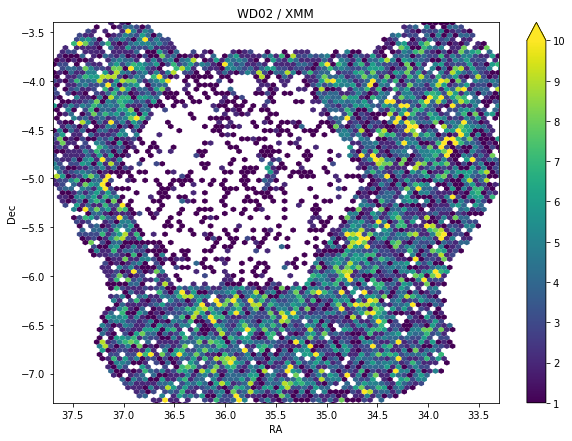

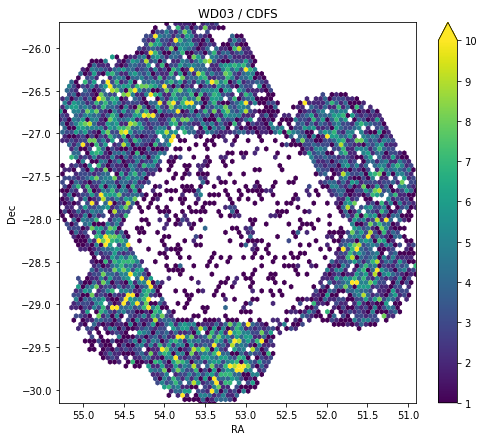

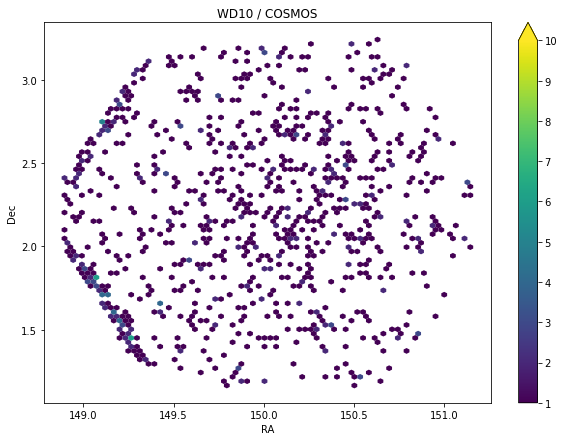

In [395]:
Fig, Ax = plt.subplots(1,1, figsize=(10,7))
Hx = Ax.hexbin(wide_ddf_etc['RA'][unq_xmm], wide_ddf_etc['DEC'][unq_xmm], 
          gridsize=80, vmax=10, edgecolors=None, mincnt=1)
Ax.set_xlim([37.7, 33.3])
Ax.set_ylim([-7.3, -3.4])
Ax.set_xlabel('RA')
Ax.set_ylabel('Dec')
Ax.set_title('WD02 / XMM')
Cb = Fig.colorbar(Hx, extend='max')

Fig, Ax = plt.subplots(1,1, figsize=(8,7))
Hx = Ax.hexbin(wide_ddf_etc['RA'][unq_cdfs], wide_ddf_etc['DEC'][unq_cdfs], 
          gridsize=80, vmax=10, edgecolors=None, mincnt=1)
Ax.set_xlim([55.3, 50.9])
Ax.set_ylim([-30.15, -25.7])
Ax.set_xlabel('RA')
Ax.set_ylabel('Dec')
Ax.set_title('WD03 / CDFS')
Cb = Fig.colorbar(Hx, extend='max')

Fig, Ax = plt.subplots(1,1, figsize=(10,7))
Hx = Ax.hexbin(wide_ddf_etc['RA'][unq_cos], wide_ddf_etc['DEC'][unq_cos], 
          gridsize=70, vmax=10, edgecolors=None, mincnt=1)
# Ax.set_xlim([37.7, 33.3])
# Ax.set_ylim([-7.3, -3.4])
Ax.set_title('WD10 / COSMOS')
Ax.set_xlabel('RA')
Ax.set_ylabel('Dec')
Cb = Fig.colorbar(Hx, extend='max')

There is a small fraction of WIDE selected targets that don't have a match in the DEEP sample. In some regions that can be seen as differences in the masking around bright sources. Others maybe due to incorrect photo-$z$s in one catalogue or the other. However, the overall fraction (~13% of COSMOS) is not huge.